# Faces Gray2RGB

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

## Prepare the dataset

In [3]:
# Un comment when downloading the dataset
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar -xvf lfw.tgz

In [4]:
data_folder = 'lfw'
lfw_names = os.listdir(data_folder)
images_list = []
for person in lfw_names:
  for file_ in os.listdir(os.path.join(data_folder, person)):
    if file_.endswith('jpg'):
      images_list.append(os.path.join(data_folder, person, file_))
print('Total: {} images'.format(len(images_list)))

Total: 13233 images


In [5]:
images_list[:10]

['lfw/Lee_Hyung-taik/Lee_Hyung-taik_0001.jpg',
 'lfw/Caio_Blat/Caio_Blat_0001.jpg',
 'lfw/Gala_Leon_Garcia/Gala_Leon_Garcia_0001.jpg',
 'lfw/Gary_Bald/Gary_Bald_0001.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0009.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0006.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0011.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0007.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0014.jpg',
 'lfw/Nicole_Kidman/Nicole_Kidman_0003.jpg']

In [6]:
train_images, test_images = train_test_split(images_list, test_size=0.2)
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 10586
Test images: 2647


In [7]:
def map_image(image_path):
  rgb = tf.io.read_file(image_path)
  rgb = tf.image.decode_jpeg(rgb, channels=3)
  rgb = tf.image.resize(rgb, (224, 224))
  gray = tf.image.rgb_to_grayscale(rgb)
  rgb = tf.cast(rgb, dtype=tf.float32)
  gray = tf.cast(gray, dtype=tf.float32)
  rgb = rgb / 255.0
  gray = gray / 255.0
  return gray, rgb

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [9]:
def encoder(inputs):
  x = tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  return x

In [13]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(bottle_neck)
  return bottle_neck, encoder_visualization

In [18]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)
  return x

In [19]:
def convolutional_autoencoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(224, 224, 1))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)  
  return model, encoder_model

In [20]:
convolutional_model, convolutional_encoder_model = convolutional_autoencoder()
convolutional_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 128)       512 

In [21]:
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [22]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                  validation_data=test_dataset, validation_steps=valid_steps, 
                                  epochs=10)

Epoch 1/10
330/330 [==============================] - 104s 206ms/step - loss: 0.0185 - val_loss: 0.0402
Epoch 2/10
330/330 [==============================] - 70s 209ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 3/10
330/330 [==============================] - 69s 209ms/step - loss: 0.0067 - val_loss: 0.0130
Epoch 4/10
330/330 [==============================] - 69s 208ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/10
330/330 [==============================] - 69s 208ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 6/10
330/330 [==============================] - 69s 209ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 7/10
330/330 [==============================] - 69s 208ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/10
330/330 [==============================] - 69s 208ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/10
330/330 [==============================] - 69s 209ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 10/10
330/330 [==============================] - 69s 208ms/step - 

## Display sample

In [23]:
from google.colab import files

In [34]:
from_dataset = False

if from_dataset:
  test_data = next(iter(test_dataset))
  idx = 3
  gray_img = test_data[0][idx]
  color_img = test_data[1][idx]
else:
  uploaded = files.upload()
  for fn in uploaded.keys():
    gray_img, color_img = map_image(fn)

Saving ew.jpeg to ew.jpeg


In [35]:
predicted = convolutional_model.predict(gray_img[tf.newaxis, ...])

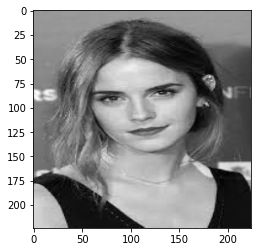

In [36]:
plt.imshow(np.squeeze(gray_img), cmap='gray')

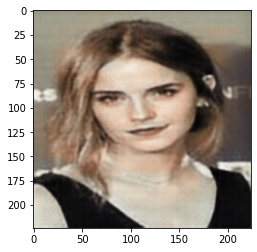

In [37]:
plt.imshow(np.squeeze(predicted))

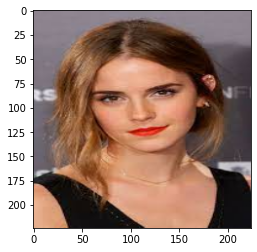

In [38]:
plt.imshow(np.squeeze(color_img))